In [2]:
import os
import requests
import pymc3 as pm
import pandas as pd
import numpy as np
import theano
import theano.tensor as tt

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.dates import date2num, num2date

from datetime import date
from datetime import datetime

from IPython.display import clear_output

%config InlineBackend.figure_format = 'retina'

In [1]:
import os

Okay take 2 on R_t. Going to heavily be pulling from Kevin Systrom's notebook on using PYMC3 to simulate. However, there is one big difference between the US data and the Canadian data. The Canadian data unfortunately does not have an onset of symptom date. There is an aggregated list released by the Canadian government, but it is 2 weeks behind and is already aggregated and therefore is not very useful for our purposes.

However, we can use MCMC (and by proxy PYMC3) to sample from the dataset, and generate a probability distribution of days onset. We consider onset symptom date to be a Weibull probability distribution from 0 - 20 days before the reported date. We pull the American dataset and run a MCMC simulation on it, to come up with optimal parameters. There's a discrete version of the Weibull Distribution which is highlighted here: https://en.wikipedia.org/wiki/Discrete_Weibull_distribution

Let X be the probability distribution describing the days before the reported date that the onset symptoms started occurring. We'll assume a Discrete Weibull on the prior:

$$ X \sim Weibull(q, \beta) $$

where $\beta$ is a shape parameter, and q is a parametrization of shape and scale. q is defined as $ q = e^{-\alpha^{-\beta}} $. For hyperparameter tuning, based on support, we choose beta to be an inverse gamma distributon, and q to follow a beta distribution.

$$ 
q \sim Beta(\alpha_1, \beta_1) \\
b \sim InverseGamma(\alpha_2, \beta_2)
$$



In [125]:
# First, download our data. Use the American dataset to fit the parameters.

def download_file(url, local_filename):
    """From https://stackoverflow.com/questions/16694907/"""
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
    return local_filename


URL = "https://github.com/beoutbreakprepared/nCoV2019/blob/master/latest_data/latestdata.tar.gz?raw=true"
LINELIST_PATH = '../data/us_linelist.csv.tar.gz'

if not os.path.exists(LINELIST_PATH):
    print('Downloading file, this will take a while ~100mb')
    try:
        download_file(URL, LINELIST_PATH)
        clear_output(wait=True)
        print('Done downloading.')
    except:
        print('Something went wrong. Try again.')
else:
    print('Already downloaded CSV')

Already downloaded CSV


In [12]:
# Untar and gzip the file
import tarfile

tar = tarfile.open(LINELIST_PATH, "r:gz")
tar.extractall(path="../data")

In [3]:
patients = pd.read_csv(
    '../data/latestdata.csv',
    parse_dates=False,
    usecols=[
        'date_confirmation',
        'date_onset_symptoms'],
    low_memory=False)
patients.columns = ['Onset', 'Confirmed']
patients = patients.replace('01.31.2020', '31.01.2020')
patients = patients.dropna()
# Must have strings that look like individual dates
# "2020.03.09" is 10 chars long
is_ten_char = lambda x: x.str.len().eq(10)
patients = patients[is_ten_char(patients.Confirmed) & 
                    is_ten_char(patients.Onset)]

# Convert both to datetimes
patients.Confirmed = pd.to_datetime(
    patients.Confirmed, format='%d.%m.%Y')
patients.Onset = pd.to_datetime(
    patients.Onset, format='%d.%m.%Y')

# Only keep records where confirmed > onset
patients = patients[patients.Confirmed >= patients.Onset]

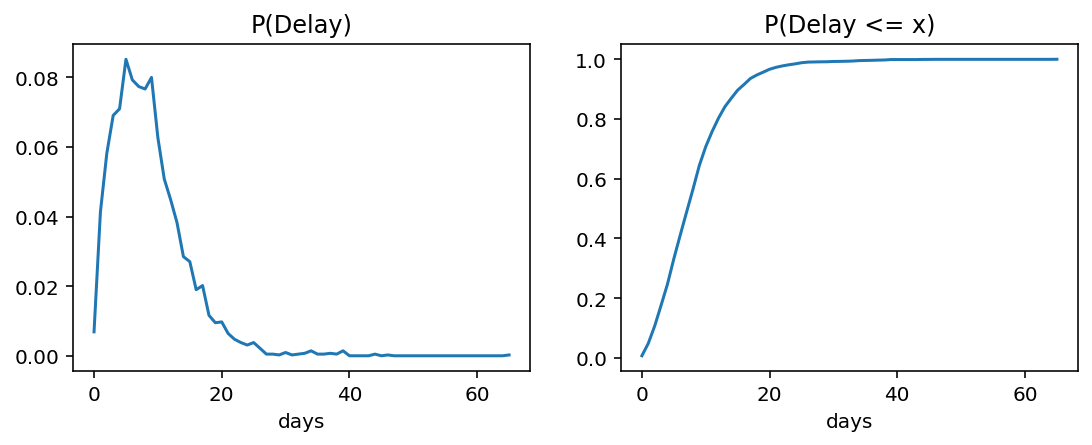

In [23]:
# Calculate the delta in days between onset and confirmation
delay = (patients.Confirmed - patients.Onset).dt.days

# Convert samples to an empirical distribution
p_delay = delay.value_counts().sort_index()
new_range = np.arange(0, p_delay.index.max()+1)
p_delay = p_delay.reindex(new_range, fill_value=0)
p_delay /= p_delay.sum()

# Show our work
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
p_delay.plot(title='P(Delay)', ax=axes[0])
p_delay.cumsum().plot(title='P(Delay <= x)', ax=axes[1])
for ax in axes:
    ax.set_xlabel('days')

In [66]:
# That is going to be our observed dataset. Construct our posterior distrbution from this
# According to https://www.medrxiv.org/content/10.1101/2020.03.06.20032417v1.full.pdf
# the onset symptoms (ie. the incubation period) can be modelled by a weibull distribution 
model = pm.Model()

with model:
    # Declare priors/unknowns
    beta = pm.InverseGamma('beta', alpha=2, beta=0.5) # Arbitrary guesses
    q = pm.Beta('q', alpha=1, beta=1)
    
    # In the future, to chain the distribution, we're going add a deterministic equation
    # But for now, just do the observed here to get a handle on what p is going to be.
    observed_onset = pm.DiscreteWeibull('onset_delay', q=q, beta=beta, observed=delay)
    
    # Set step function and sample
    step = pm.Slice()
    trace = pm.sample(10000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [q, beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 22000/22000 [01:39<00:00, 221.57draws/s]
The number of effective samples is smaller than 25% for some parameters.


/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWar

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2494cd50>,
      dtype=object)

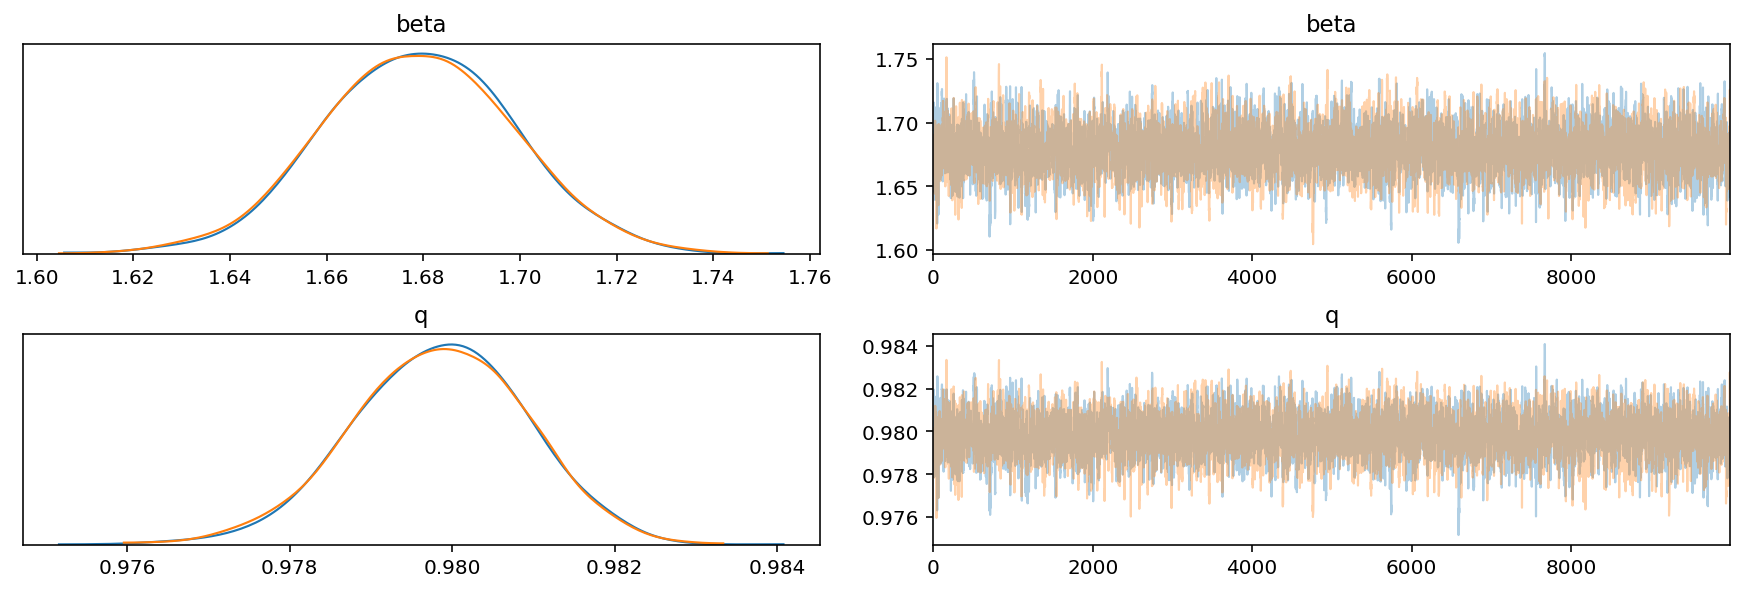

In [67]:
pm.traceplot(trace)

In [68]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta,1.679,0.020,1.642,1.716,0.0,0.0,3484.0,3484.0,3496.0,4250.0,1.0
q,0.980,0.001,0.978,0.982,0.0,0.0,3426.0,3426.0,3462.0,4360.0,1.0


So the graph gives us that the onset delay is most likely to follow a distribution of 

$$ X \sim Weibull(\alpha, \beta) $$

To confirm our sanity, we are going to model a distcretized Weibull distribution, and map it up to the p_delay

/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the drawstyle with the linestyle as a single string is deprecated since Matplotlib 3.1 and support will be removed in 3.3; please pass the drawstyle separately using the drawstyle keyword argument to Line2D or set_drawstyle() method (or ds/set_ds()).


Text(0.5, 1.0, 'Probability of Onset Symptoms modeled by a Weibull ')

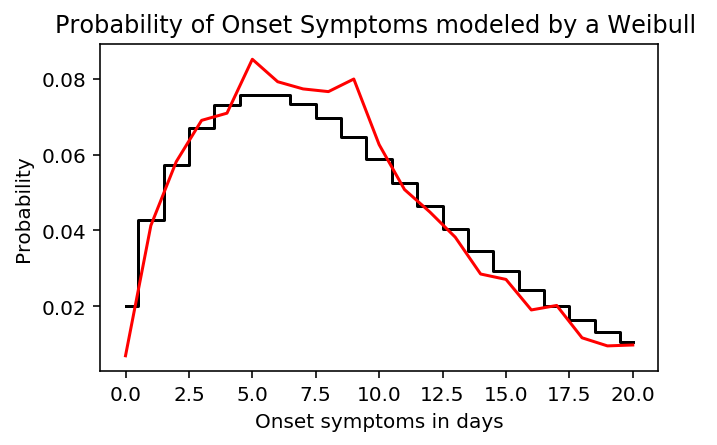

In [76]:
import math

q = 0.980
beta = 1.679
x = np.linspace(0, 20, 21)

dist = q**(x**beta) - q**((x+1)**beta)

fig, ax = plt.subplots(figsize=(5,3))

plt.plot(x, dist, color='black', linestyle='steps-mid-')
plt.plot(x, p_delay[:21], color='red')


ax.set_ylabel("Probability")
ax.set_xlabel("Onset symptoms in days")
ax.set_title("Probability of Onset Symptoms modeled by a Weibull ")


In [82]:
# Adjust for right-censoring.
def confirmed_to_onset(confirmed, p_delay):

    assert not confirmed.isna().any()
    
    # Reverse cases so that we convolve into the past
    convolved = np.convolve(confirmed[::-1].values, p_delay)

    # Calculate the new date range
    dr = pd.date_range(end=confirmed.index[-1],
                       periods=len(convolved))

    # Flip the values and assign the date range
    onset = pd.Series(np.flip(convolved), index=dr)
    
    return onset

def adjust_onset_for_right_censorship(onset, p_delay):
    cumulative_p_delay = p_delay.cumsum()
    
    # Calculate the additional ones needed so shapes match
    ones_needed = len(onset) - len(cumulative_p_delay)
    padding_shape = (0, ones_needed)
    
    # Add ones and flip back
    cumulative_p_delay = np.pad(
        cumulative_p_delay,
        padding_shape,
        constant_values=1)
    cumulative_p_delay = np.flip(cumulative_p_delay)
    
    # Adjusts observed onset values to expected terminal onset values
    adjusted = onset / cumulative_p_delay
    
    return adjusted, cumulative_p_delay


In [78]:
# Now download Candian dataset and use as our linelist.

URL = "https://raw.githubusercontent.com/ishaberry/Covid19Canada/master/cases.csv"
LINELIST_PATH = '../data/linelist.csv'
download_file(URL, LINELIST_PATH)

date_parser = lambda d: datetime.strptime(d, "%d-%m-%Y")

df = pd.read_csv('../data/linelist.csv', parse_dates=['date_report'], date_parser=date_parser)
#"case_id","provincial_case_id","age","sex","health_region","province","country","date_report","report_week","travel_yn","travel_history_country","locally_acquired","case_source","additional_info","additional_source","method_note"
# Filter by province because data is not complete for some provinces
df = df[~df['province'].isin(['Nunavut', 'Repatriated'])]
df

,case_id,provincial_case_id,age,sex,health_region,province,country,date_report,report_week,travel_yn,travel_history_country,locally_acquired,case_source,additional_info,additional_source,method_note
0,1,1,50-59,Male,Toronto,Ontario,Canada,2020-01-25,19-01-2020,1,China,NaN,(1) https://news.ontario.ca/mohltc/en/2020/01/...,NaN,NaN,0.0
1,2,2,50-59,Female,Toronto,Ontario,Canada,2020-01-27,26-01-2020,1,China,NaN,(1) https://news.ontario.ca/mohltc/en/2020/01/...,Travel and Close Contact,NaN,0.0
2,3,1,40-49,Male,Vancouver Coastal,BC,Canada,2020-01-28,26-01-2020,1,China,NaN,https://news.gov.bc.ca/releases/2020HLTH0015-0...,NaN,NaN,NaN
3,4,3,20-29,Female,Middlesex-London,Ontario,Canada,2020-01-31,26-01-2020,1,China,NaN,(1) https://news.ontario.ca/mohltc/en/2020/01/...,NaN,NaN,0.0
4,5,2,50-59,Female,Vancouver Coastal,BC,Canada,2020-02-04,02-02-2020,0,NaN,Close Contact,https://news.gov.bc.ca/releases/2020HLTH0023-0...,The individual had close contact with family v...,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77067,77068,23517,Not Reported,Not Reported,York,Ontario,Canada,2020-05-16,10-05-2020,Not Reported,NaN,NaN,https://www.york.ca/wps/portal/yorkhome/health...,NaN,NaN,0.0
77068,77069,23518,Not Reported,Not Reported,York,Ontario,Canada,2020-05-16,10-05-2020,Not Reported,NaN,NaN,https://www.york.ca/wps/portal/yorkhome/health...,NaN,NaN,0.0
77069,77070,23519,Not Reported,Not Reported,York,Ontario,Canada,2020-05-16,10-05-2020,Not Reported,NaN,NaN,https://www.york.ca/wps/portal/yorkhome/health...,NaN,NaN,0.0
77070,77071,23520,Not Reported,Not Reported,York,Ontario,Canada,2020-05-16,10-05-2020,Not Reported,NaN,NaN,https://www.york.ca/wps/portal/yorkhome/health...,NaN,NaN,0.0


In [102]:
cases = df[df['province'] == 'Ontario'].groupby(['province', 'date_report']).count()[['case_id']].rename(columns={"case_id": 'confirmed_cases_by_day'})
province_df = cases['confirmed_cases_by_day']
province_df

province  date_report
Ontario   2020-01-25       1
          2020-01-27       1
          2020-01-31       1
          2020-02-23       1
          2020-02-26       1
                        ... 
          2020-05-12     345
          2020-05-13     357
          2020-05-14     363
          2020-05-15     395
          2020-05-16     374
Name: confirmed_cases_by_day, Length: 82, dtype: int64

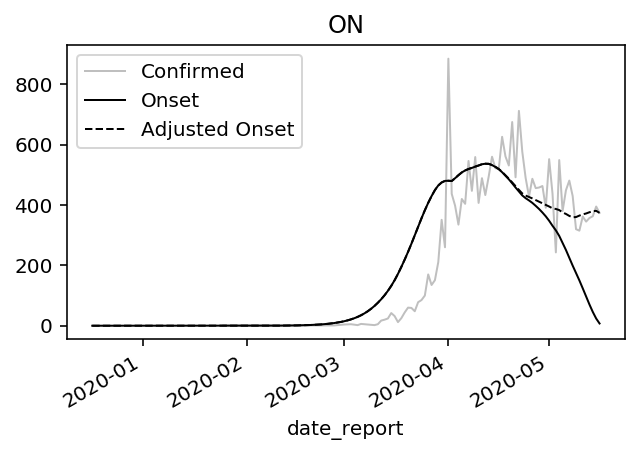

In [119]:
confirmed = province_df.to_frame().reset_index(level=[0]).drop(columns=['province'])['confirmed_cases_by_day']
# The goal is to wrap this into a pymc3 sampling box, but let's get to the end first.
# Construct the delay list as a pandas series with the weibull fitted distribution
q = 0.980
beta = 1.679
x = np.linspace(0, 70, 71)
p_delay = q**(x**beta) - q**((x+1)**beta)

onset = confirmed_to_onset(confirmed, p_delay)
adjusted, cumulative_p_delay = adjust_onset_for_right_censorship(onset, p_delay)
fig, ax = plt.subplots(figsize=(5,3))

confirmed.plot(
    ax=ax,
    label='Confirmed',
    title='ON',
    c='k',
    alpha=.25,
    lw=1)

onset.plot(
    ax=ax,
    label='Onset',
    c='k',
    lw=1)

adjusted.plot(
    ax=ax,
    label='Adjusted Onset',
    c='k',
    linestyle='--',
    lw=1)

ax.legend();


Okay, we have parity with the American dataset now! Let's simulate our R_t Gaussian random walk. Recall our goal here: We assume a poisson likelihood function and feed it what we believe is the onset curve based on reported data. We model this onset curve based on the same math in the previous notebook: 

\begin{eqnarray}
I'= Ie^{\gamma(R_t - 1)}
\end{eqnarray}

We denote $ \theta = \gamma(R_t - 1) $ to simplify the random walk equation to $ I' = Ie^{\theta}$. In our walk, we let $ \gamma $ be our serial interval, and leverage MCMC to determine the distribution of that value. 

After all this is done, we will arrive at $ R_t $ with the equation 


$$ R_t = \frac{\theta}{\gamma} + 1 $$



In [109]:
# Now try sampling with a Gaussian Random walk strategy
chains=1 
tune=3000 
draws=1000
target_accept=.95

with pm.Model() as gauss_model:

    # Random walk magnitude
    step_size = pm.HalfNormal('step_size', sigma=.03)

    # Theta random walk
    theta_raw_init = pm.Normal('theta_raw_init', 0.1, 0.1)
    theta_raw_steps = pm.Normal('theta_raw_steps', shape=len(onset)-2) * step_size
    theta_raw = tt.concatenate([[theta_raw_init], theta_raw_steps])
    theta = pm.Deterministic('theta', theta_raw.cumsum())

    # Let the serial interval be a random variable and calculate r_t
    serial_interval = pm.Gamma('serial_interval', alpha=6, beta=1.5)
    gamma = 1.0 / serial_interval
    r_t = pm.Deterministic('r_t', theta/gamma + 1)

    inferred_yesterday = onset.values[:-1] / cumulative_p_delay[:-1]

    expected_today = inferred_yesterday * cumulative_p_delay[1:] * pm.math.exp(theta)

    # Ensure cases stay above zero for poisson
    mu = pm.math.maximum(.1, expected_today)
    observed = onset.round().values[1:]
    cases = pm.Poisson('cases', mu=mu, observed=observed)

    trace = pm.sample(
        chains=chains,
        tune=tune,
        draws=draws,
        target_accept=target_accept)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [serial_interval, theta_raw_steps, theta_raw_init, step_size]
Sampling chain 0, 0 divergences: 100%|██████████| 4000/4000 [01:37<00:00, 40.87it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [114]:
def df_from_trace(trace):
    
    r_t = trace['r_t']
    mean = np.mean(r_t, axis=0)
    median = np.median(r_t, axis=0)
    hpd_90 = pm.stats.hpd(r_t, credible_interval=.9)
    hpd_50 = pm.stats.hpd(r_t, credible_interval=.5)
    
    idx = pd.MultiIndex.from_product([
            ['ON'],
            onset.index[1:]
        ], names=['region', 'date'])
        
    df = pd.DataFrame(data=np.c_[mean, median, hpd_90, hpd_50], index=idx,
                 columns=['mean', 'median', 'lower_90', 'upper_90', 'lower_50','upper_50'])
    return df

In [115]:
df_from_trace(trace)

mean    median  lower_90  upper_90  lower_50  upper_50
region date                                                                  
ON     2019-12-18  1.465199  1.407255  1.017809  2.166110  1.118952  1.537023
       2019-12-19  1.464965  1.409580  0.898727  2.018726  1.145186  1.562211
       2019-12-20  1.466944  1.408105  0.950187  2.085401  1.085738  1.516883
       2019-12-21  1.466487  1.414977  0.919422  2.011880  1.170796  1.594925
       2019-12-22  1.466405  1.407289  0.968289  2.085294  1.116721  1.533422
...                     ...       ...       ...       ...       ...       ...
       2020-05-12  0.975154  0.979784  0.781586  1.138777  0.921484  1.039249
       2020-05-13  0.977618  0.979873  0.794060  1.177728  0.917024  1.042452
       2020-05-14  0.980051  0.982016  0.759819  1.155428  0.910328  1.043671
       2020-05-15  0.977495  0.977289  0.745215  1.167122  0.913174  1.054447
       2020-05-16  0.977537  0.980559  0.769800  1.210032  0.911163  1.057327

[151 rows x 6 columns]

In [120]:
def plot_rt(name, result, ax, c=(.3,.3,.3,1), ci=(0,0,0,.05)):
    ax.set_ylim(0.5, 1.6)
    ax.set_title(name)
    ax.plot(result['median'],
            marker='o',
            markersize=4,
            markerfacecolor='w',
            lw=1,
            c=c,
            markevery=2)
    ax.fill_between(
        result.index,
        result['lower_90'].values,
        result['upper_90'].values,
        color=ci,
        lw=0)
    ax.axhline(1.0, linestyle=':', lw=1)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWar

/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWar

/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWar

/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWar

/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWar

/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWar

/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWar

/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWar

/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWar

/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWar

/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/Users/ivanpeng/opt/anaconda3/envs/rt_covid/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWar

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2f63bdd0>,
      dtype=object)

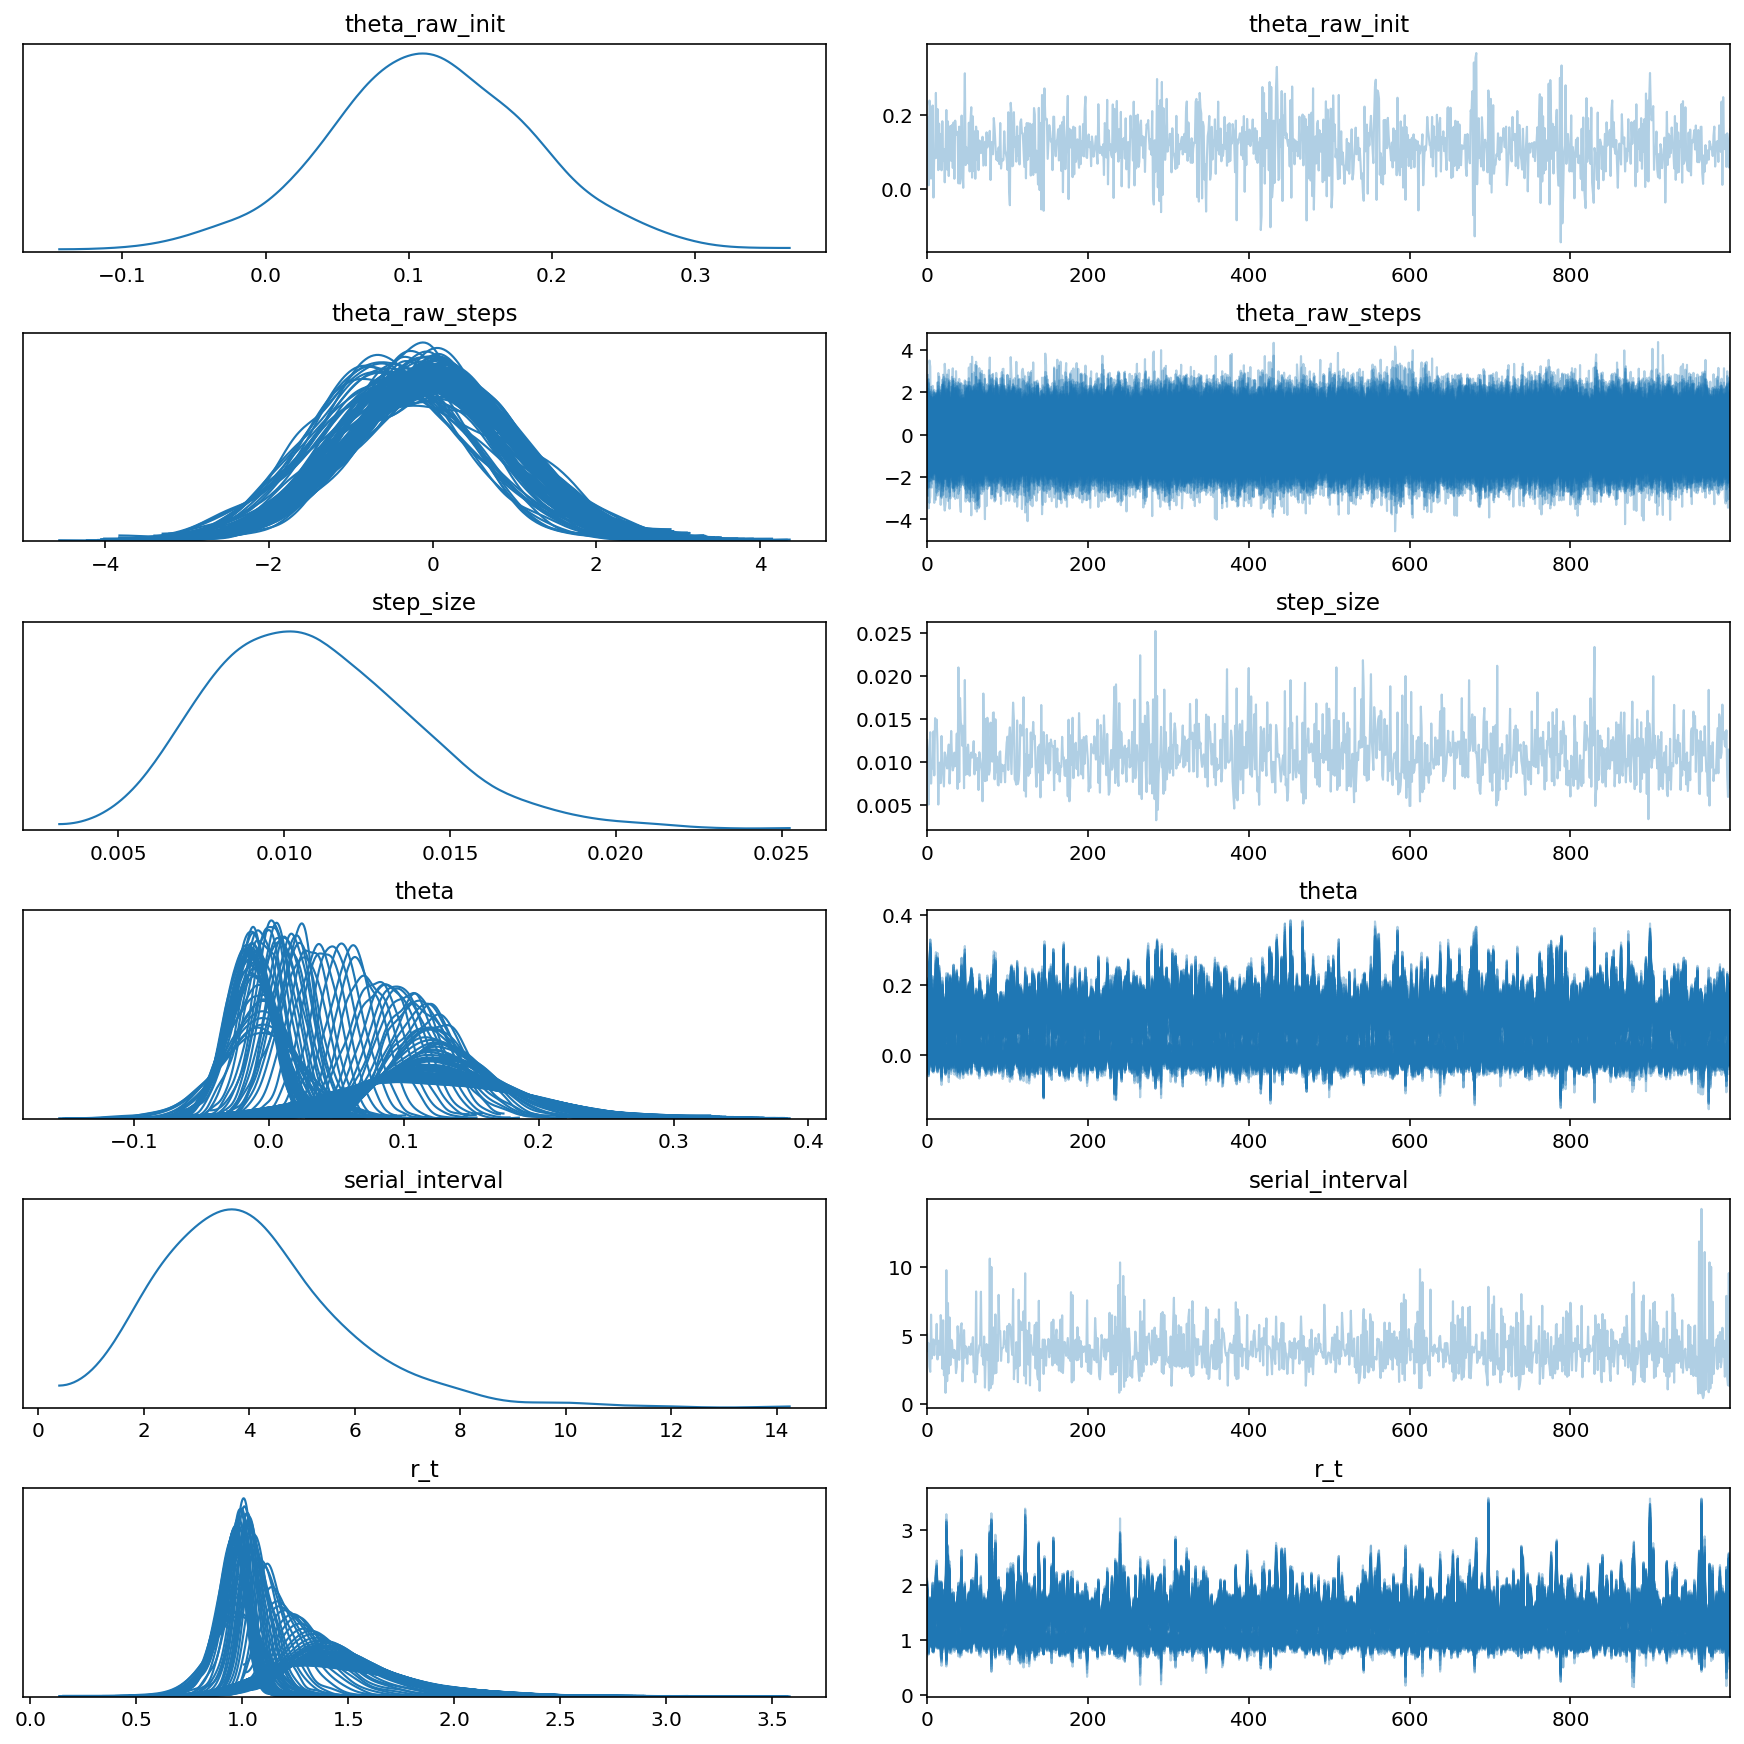

In [122]:
pm.traceplot(trace)

In [123]:
pm.summary(trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta_raw_init,0.115,0.074,-0.025,0.259,0.002,0.002,1451.0,644.0,1431.0,461.0,NaN
theta_raw_steps[0],0.005,0.925,-1.826,1.672,0.019,0.034,2323.0,373.0,2315.0,639.0,NaN
theta_raw_steps[1],0.033,1.048,-1.932,1.822,0.021,0.040,2386.0,339.0,2423.0,570.0,NaN
theta_raw_steps[2],0.033,1.014,-2.023,1.833,0.019,0.037,2774.0,379.0,2742.0,755.0,NaN
theta_raw_steps[3],-0.022,0.999,-1.646,2.101,0.020,0.048,2557.0,219.0,2572.0,489.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
r_t[146],0.975,0.116,0.759,1.204,0.003,0.002,1165.0,1165.0,1359.0,842.0,NaN
r_t[147],0.978,0.124,0.722,1.184,0.004,0.003,1075.0,1060.0,1178.0,867.0,NaN
r_t[148],0.980,0.135,0.724,1.219,0.004,0.003,1018.0,991.0,1226.0,875.0,NaN
r_t[149],0.977,0.147,0.736,1.232,0.005,0.004,959.0,854.0,1223.0,878.0,NaN


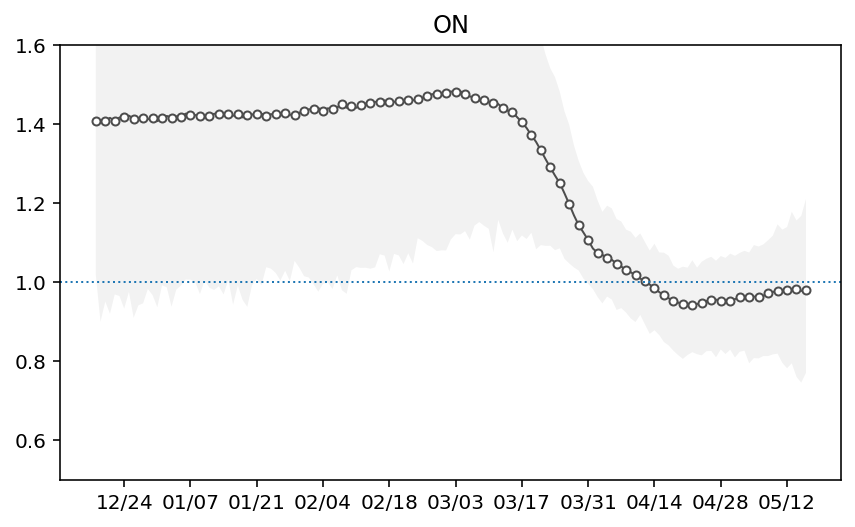

In [124]:
fig, ax = plt.subplots(figsize=(7,4))
plot_rt("ON", df_from_trace(trace).droplevel(0), ax)

In [ ]:
# TODO: How do we combine both the Gaussian random walk and the p_delay sampling together? 
# Would need to add the report to onset conversion, and our observed variables is the report date. 
# It's certainly possible. We will have 2 observed datasets informing our distribution
# I think the marginal gains of sampling that distribution are not worth the time at the moment.
# Will investigate to see how much more of the HPDs they do infer. 